In [1]:
import numpy as np
import pandas as pd
from plotnine import *

In [87]:
df_test = pd.read_csv('evalData.csv')

In [2]:
df_train = pd.read_csv('trainData.csv')
df_train.head()

,Unnamed: 0,date,fligth_number,origin,destination,distance,noshow,denied_boarding,pax_midlow,pax_high,...,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings
0,389083,2009-11-09,8995,BBA,SCL,1394,9.0,0,94,2,...,22,19,0,1,0,239,10:30:00,174.0,10631.1,240
1,177073,2009-05-23,7061,LIM,TRU,489,0.0,0,100,4,...,25,0,0,19,9,192,19:20:00,174.0,5453.7,220
2,1040357,2011-05-09,8972,SCL,PUQ,2180,4.0,0,7,1,...,2,0,0,0,10,69,09:54:00,218.0,16161.0,79
3,505258,2010-02-12,6039,CGH,CNF,524,13.0,0,54,4,...,4,0,0,26,0,64,21:00:00,174.0,10828.7,90
4,369663,2009-10-24,7713,GPS,GYE,1170,14.0,0,21,88,...,0,88,1,23,3,183,12:40:00,144.0,16721.6,209


# Limpieza de datos

In [3]:
# Eliminar columna Unnamed: 0; parece ser un identificador innecesario
df_train = df_train.drop(columns=["Unnamed: 0"])

In [144]:
df_train['fligth_number'].nunique()
len(df_train)/df_train['fligth_number'].nunique() # hay app 237 vuelos para cada flight number, no es una 'etiqueta' unica por vuelo, quizas sirve

237.98657050484954

Revisar datos faltantes:

In [4]:
df_train.isna().sum()
# La variable departure_time "hora programada de despegue" presenta datos nulos

date                  0
fligth_number         0
origin                0
destination           0
distance              0
noshow                0
denied_boarding       0
pax_midlow            0
pax_high              0
pax_midhigh           0
pax_low               0
pax_freqflyer         0
group_bookings        0
out_of_stock          0
dom_cnx               0
int_cnx               0
p2p                   0
departure_time     1418
capacity              0
revenues_usd          0
bookings              0
dtype: int64

Se tienen sólo 1418 valores faltantes en la variable 'departure_time'.
Consideramos que esta variable puede ser relevante para el trabajo, porque indica la hora en que debe salir el avión, y es probable que esto afecte en la cantidad de 'no show'. 
Como se tienen 999890 filas, y 1418 filas con datos faltantes, son sólo el 0.14% de los datos.

Podriamos eliminar los nulos, pero como el df_test tambien tiene faltantes y necesitamos predecir si o si todos los test, podemos
- eliminar la variable completa
- imputar por media o mediana


Por mientras, imputamos por la mediana.
Pero para esto, primero tenemos que trabajar los formatos, no se puede calcular la mediana con el formato hh:mm:ss

**Revisar los Formatos:**

Para las variables de fechas y tiempo, debemos ajustar los formatos, ya que no nos sirven tal como están para el modelo.
- **date:** esta en formato yyyy:mm:dd. Para predecir, no nos interesa realmente el año, no entrega info. para predecir (no vamos a volver a esos años). El día del mes tampoco es relevante, considerando el problema. El mes podría contener información interesante, por ejemplo por las fechas que tienen más viajes como Navidad, por lo que dejamos sólo esa información.

Quizás podemos sacar date? Para tener menos variables y no creo que sea muy relevante (hay viajes todo el año)

- **departure_time:** La variable 'departure_time' tiene formato hh:mm:ss. No nos sirve así, y la información realmente relevante es la hora en sí (hh), por lo que conservamos sólo esa parte. (Quizás viajes en la madrugada se pierden más pq no llegan o algo así?)

In [5]:
import pandas as pd

# Transformación para date:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['month'] = df_train['date'].dt.month
df_train = df_train.drop(columns='date')

# Transformación para departure_time:
df_train['departure_time'] = pd.to_datetime(df_train['departure_time'], errors='coerce')  # Transformación y manejo de NaT
# Extrae solo la hora de inicio (hh) y reemplaza NaT con un -1 por mientras
df_train['departure_time'] = df_train['departure_time'].apply(lambda x: x.hour if not pd.isna(x) else -1)

# Calcula la mediana de las horas de inicio (ignorando los valores -1)
median_departure_time = df_train['departure_time'][df_train['departure_time'] != -1].median()

# Imputa los valores -1 en 'departure_time' con la mediana
df_train['departure_time'].replace(-1, median_departure_time, inplace=True)

C:\Users\acata\AppData\Local\Temp\ipykernel_25296\364324107.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


**Con respecto a las variables categóricas nominales:**
- origin: Aeropuerto de origen
- destination: Aeropuerto de destino

Consideramos la opción de hacer one-hot encoding, lo que crearía demasiadas variables binarias, las que no son ideales para métodos de distancia como KNN-regressor (ya que no existe un concepto real de distancia). 
Entonces, considerando que la información sobre el aeropuerto no parece vital para predecir el número de no-shows, no consideraremos estas en el df final.

Luego, para la variable 
- 'denied_boarding': indica el número de pasajeros que no pudieron abordar por vuelo sobre reservado. 

Como el objetivo principal de este proyecto es estimar el número de no show en su vuelo, **antes** de que salga un vuelo, no se debería usar esta variable como predictora, por lo que tampoco se considera en el df.

In [6]:
# Eliminar las columnas origin, destination y denied_boarding del df
columnas_eliminar = ['origin', 'destination', 'denied_boarding']
df_train = df_train.drop(columns=columnas_eliminar)

Para las **variables numéricas**, hacemos boxplots para tener una idea general de los datos y ver posibles outliers

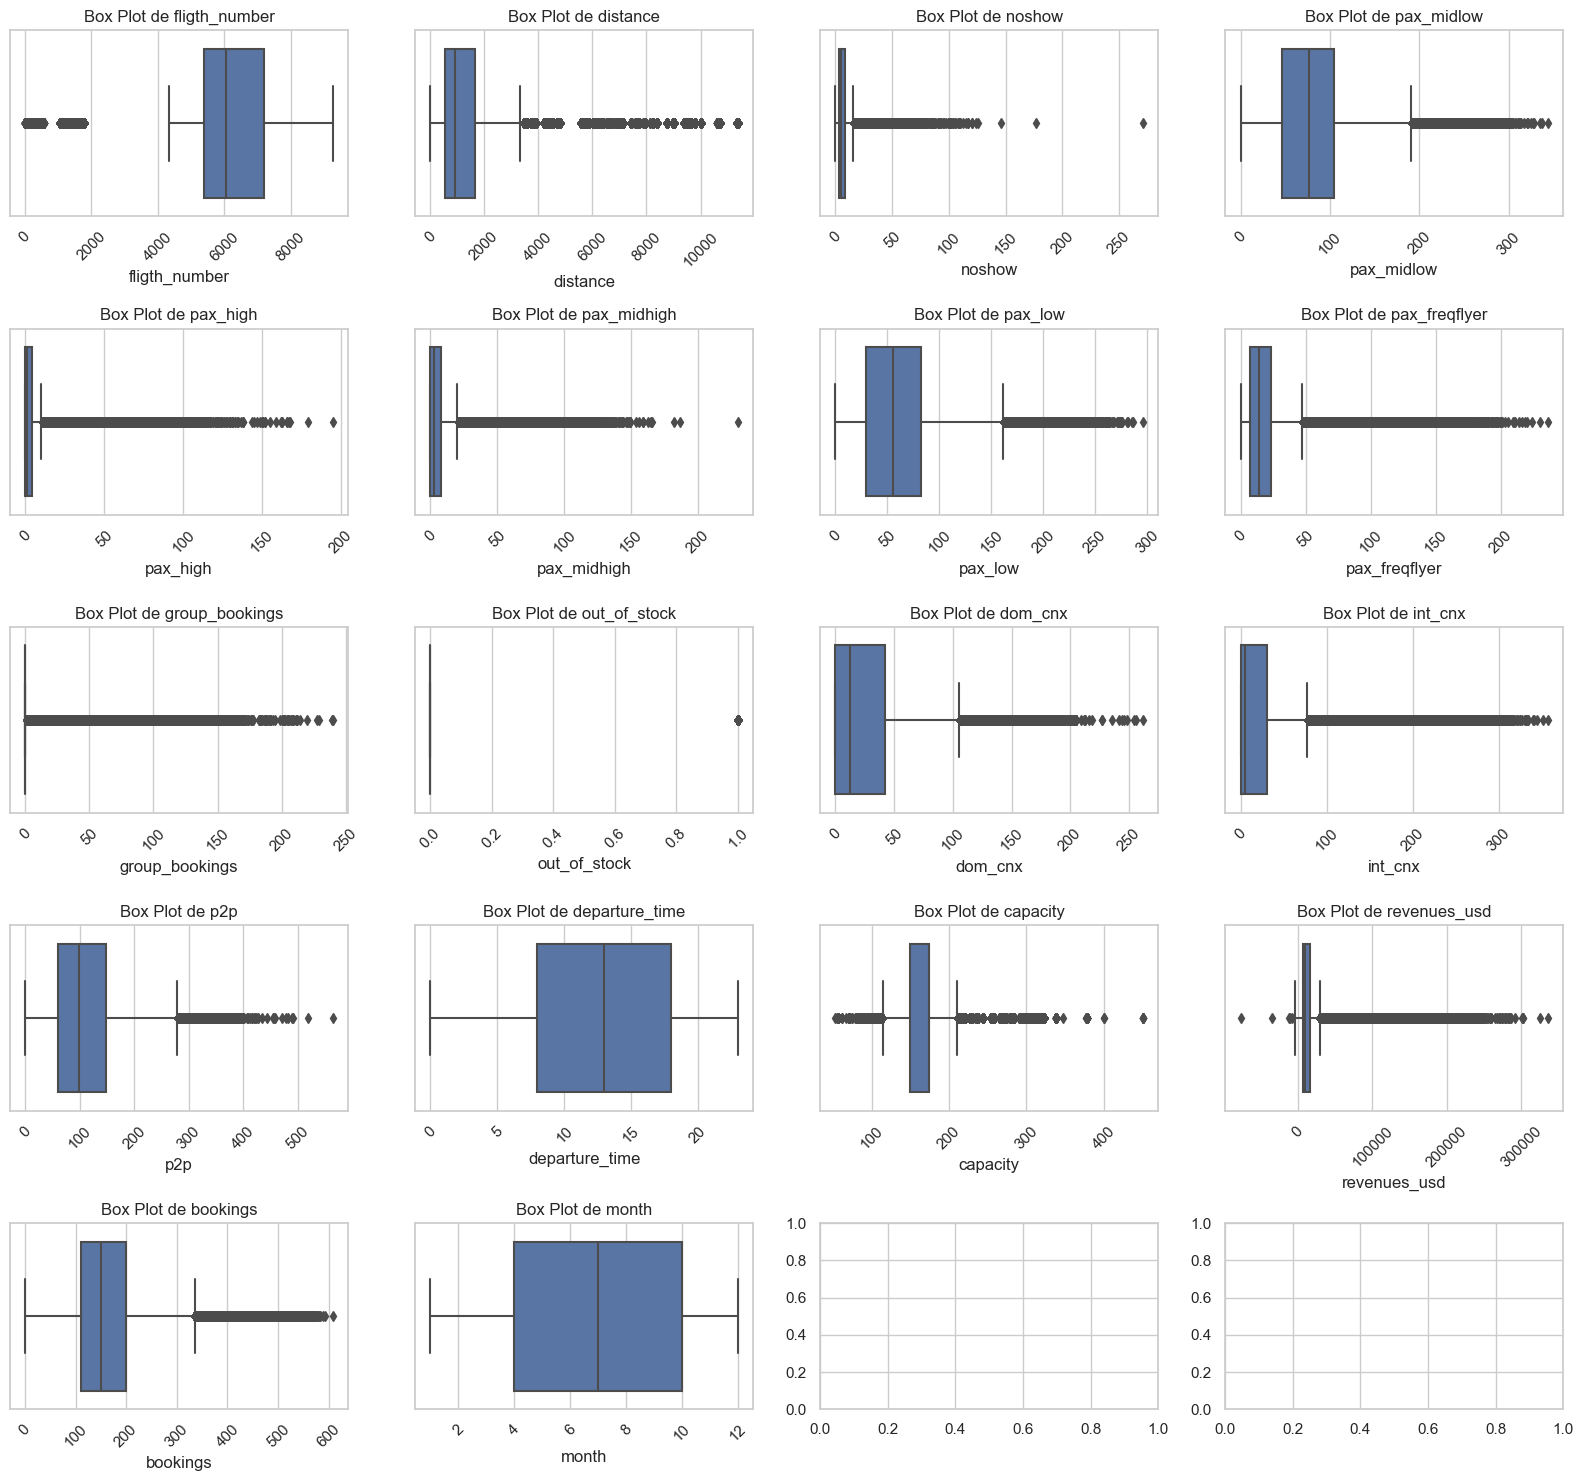

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df_train.select_dtypes(include=['number']).columns
sns.set(style="whitegrid")
plots_per_row = 4
num_rows = (len(numeric_columns) + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(16, 3 * num_rows))

for i, column in enumerate(numeric_columns):
    row = i // plots_per_row
    col = i % plots_per_row
    sns.boxplot(data=df_train, x=column, ax=axes[row, col])
    axes[row, col].set_xlabel(column)
    axes[row, col].set_title(f'Box Plot de {column}')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Podemos ver que en la variable 'revenues_usd' hay valores negativos. Estos probablemente son outliers, ya que esta variable indica ingresos en dólares, por lo que no deberían ser negativos. Como son sólo 7 valores, eliminaremos las filas que los contienen.

In [8]:
import pandas as pd
negative_revenues = df_train[df_train['revenues_usd'] < 0]
num_negative_values = len(negative_revenues)
print("Valores negativos en 'revenues_usd':")
print(negative_revenues['revenues_usd'])
print(f"Total de valores negativos: {num_negative_values}")
df_train = df_train[df_train['revenues_usd'] >= 0]

Valores negativos en 'revenues_usd':
15266    -11811.9
616862    -1487.8
685025   -34733.8
755252   -10553.2
791774    -4345.4
884149   -77206.9
892781    -8185.4
Name: revenues_usd, dtype: float64
Total de valores negativos: 7


En la variable **'noshow'** hay unos valores muy altos, especialmente uno cercano a 300, que son observaciones inusuales que pueden distorsionar la capacidad del modelo para hacer predicciones precisas. Es posible que estos valores altos sean el resultado de eventos excepcionales o errores en la recolección de datos, lo que hace que no sean representativos del comportamiento típico de los pasajeros en vuelos.

La inclusión de estos valores atípicos en el modelo puede llevar a una sobreestimación de la variabilidad en la variable objetivo 'noshow,' lo que a su vez puede afectar negativamente la calidad de las predicciones. Por lo tanto, se opta por eliminar estos valores atípicos para mejorar la precisión y la capacidad de generalización del modelo, asegurándose de que esté entrenado en datos más representativos de la población de pasajeros.

Para esto, calculamos el rango intercuartílico (IQR) de la variable 'noshow', que es una medida estadística que nos permite identificar la dispersión de los datos alrededor de la mediana. Posteriormente, definimos un umbral basado en el IQR y la regla del 1.5 veces el IQR por encima del tercer cuartil. Cualquier valor de 'noshow' que excediera este umbral fue considerado como un valor atípico. La razón para elegir el método del IQR es su capacidad para detectar valores extremos sin verse afectado por la presencia de valores atípicos en sí. 

In [9]:
import numpy as np

# Calcula el IQR de la variable 'noshow'
Q1 = np.percentile(df_train['noshow'], 25)
Q3 = np.percentile(df_train['noshow'], 75)
IQR = Q3 - Q1

# Define un umbral para valores atípicos
umbral = Q3 + 1.5 * IQR

# Identifica los valores atípicos
valores_atipicos = df_train[df_train['noshow'] > umbral]

# Cuenta los valores atípicos
cantidad_valores_atipicos = len(valores_atipicos)

# Imprime la cantidad de valores atípicos
print('IQR:', IQR)
print('umbral: ', umbral)
print(f"Número de valores atípicos en 'noshow': {cantidad_valores_atipicos}")

# Filtrar para eliminar las filas con valores atípicos
df_train = df_train[df_train['noshow'] <= umbral]

IQR: 5.0
umbral:  15.5
Número de valores atípicos en 'noshow': 42939


*¿Serán outliers los muy altos en las otras variables?*

In [55]:
df_train

,fligth_number,distance,noshow,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings,month
0,8995,1394,9.0,94,2,28,94,22,19,0,1,0,239,10,174.0,10631.1,240,11
1,7061,489,0.0,100,4,4,87,25,0,0,19,9,192,19,174.0,5453.7,220,5
2,8972,2180,4.0,7,1,5,64,2,0,0,0,10,69,9,218.0,16161.0,79,5
3,6039,524,13.0,54,4,7,21,4,0,0,26,0,64,21,174.0,10828.7,90,2
4,7713,1170,14.0,21,88,18,82,0,88,1,23,3,183,12,144.0,16721.6,209,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,6024,552,5.0,25,12,20,4,12,0,0,64,9,0,15,144.0,14102.1,73,10
999886,6669,3934,4.0,129,3,19,121,2,20,0,0,118,156,8,168.0,32907.8,274,5
999887,9094,1430,5.0,2,1,0,108,20,36,0,7,0,124,14,218.0,13519.3,131,4
999888,7704,1091,2.0,67,2,7,42,16,0,0,34,2,98,8,144.0,8729.6,134,4


Como tenemos que seleccionar un conjunto de variables para entrenar modelos distintos (knn y regression tree), probamos seleccionando las que funcionan mejor para ambos por separado, y después hacer un conjunto final que contenga las características seleccionadas por ambos 

# Forward selection para knn

In [81]:
import pandas as pd
# Hacer una muestra aleatoria para ahorrar tiempo
sample_size = 300000 # cerca del 30% de los datos
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

In [82]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, # 5 fold cross validation
    n_features_to_select='auto', # depende de 'tol'
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=5)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time', 'capacity'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 121.12082970466598


In [83]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

n_neighbors = 10
# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Puedes elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, 
    n_features_to_select='auto', # depende de 'tol'
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 119.95486709727865


In [84]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

import pandas as pd
# Hacer una muestra aleatoria para ahorrar tiempo
sample_size = round(956944/2) # 50% de los datos
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

n_neighbors = 10
# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Puedes elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, 
    n_features_to_select='auto', # depende de 'tol'
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time', 'capacity'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 119.35364983250236


In [85]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

import pandas as pd
# Hacer una muestra aleatoria para ahorrar tiempo
sample_size = round(956944/2) # 50% de los datos
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

# Define una función para calcular SMAPE
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(2 * num / den)

n_neighbors = 5
# Inicializa el modelo KNN Regressor
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn,           # El modelo
    direction='forward',  # Puedes elegir 'forward', 'backward' u 'auto'
    scoring=make_scorer(smape, greater_is_better=False),  # Función de puntuación
    cv=5, 
    n_features_to_select='auto', # depende de 'tol'
    tol=0.1) # para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escala tus datos (importante para KNN)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))

# Ajusta el SequentialFeatureSelector a tus datos
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtén las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor en las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación SMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

# Imprime la puntuación SMAPE del conjunto de características seleccionado
print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time', 'month'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 116.76591360349262


# Selección de variables para regression tree

Ver el max_depth óptimo usando todas las variables

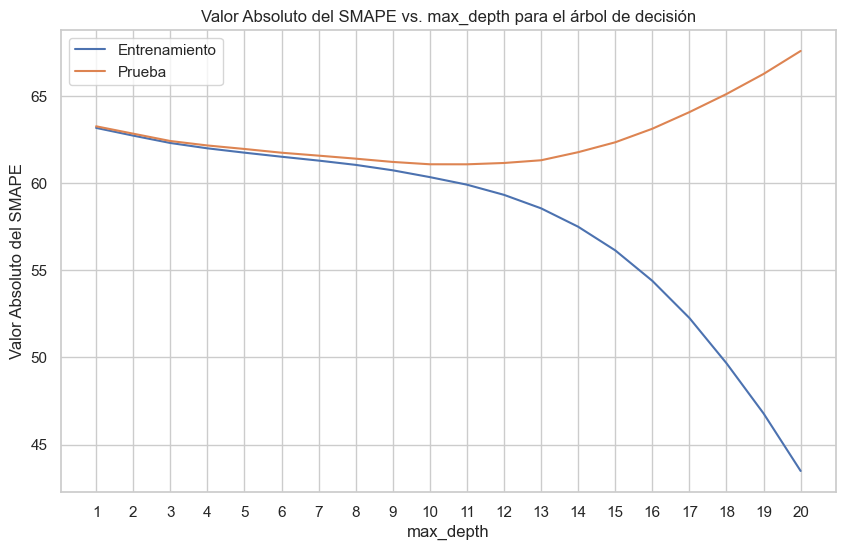

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

sample_size = round(956944/2) 
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

X = df_train_sample.drop('noshow', axis=1)
y = df_train_sample['noshow']

# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define una lista de valores de max_depth que deseas probar
max_depth_values = range(1, 21)

# Inicializa listas para almacenar las puntuaciones de entrenamiento y prueba
train_smape = []
test_smape = []

# Realiza un bucle sobre los valores de max_depth
for max_depth in max_depth_values:
    # Crea un modelo de árbol de decisión con el valor actual de max_depth
    model = DecisionTreeRegressor(max_depth=max_depth)

    # Entrena el modelo en el conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Realiza las predicciones en el conjunto de entrenamiento
    y_pred_train = model.predict(X_train)

    # Calcula el SMAPE en el conjunto de entrenamiento
    train_smape_score = np.abs(smape(y_train, y_pred_train))

    # Realiza las predicciones en el conjunto de prueba
    y_pred_test = model.predict(X_test)

    # Calcula el SMAPE en el conjunto de prueba
    test_smape_score = np.abs(smape(y_test, y_pred_test))

    # Agrega los valores de SMAPE a las listas
    train_smape.append(train_smape_score)
    test_smape.append(test_smape_score)

# Crea un gráfico de max_depth vs. valor absoluto del SMAPE
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_smape, label='Entrenamiento')
plt.plot(max_depth_values, test_smape, label='Prueba')
plt.xlabel('max_depth')
plt.ylabel('Valor Absoluto del SMAPE')
plt.title('Valor Absoluto del SMAPE vs. max_depth para el árbol de decisión')
plt.xticks(max_depth_values)
plt.legend()
plt.grid(True)
plt.show()

Entrenar el modelo usando max_depth = 5

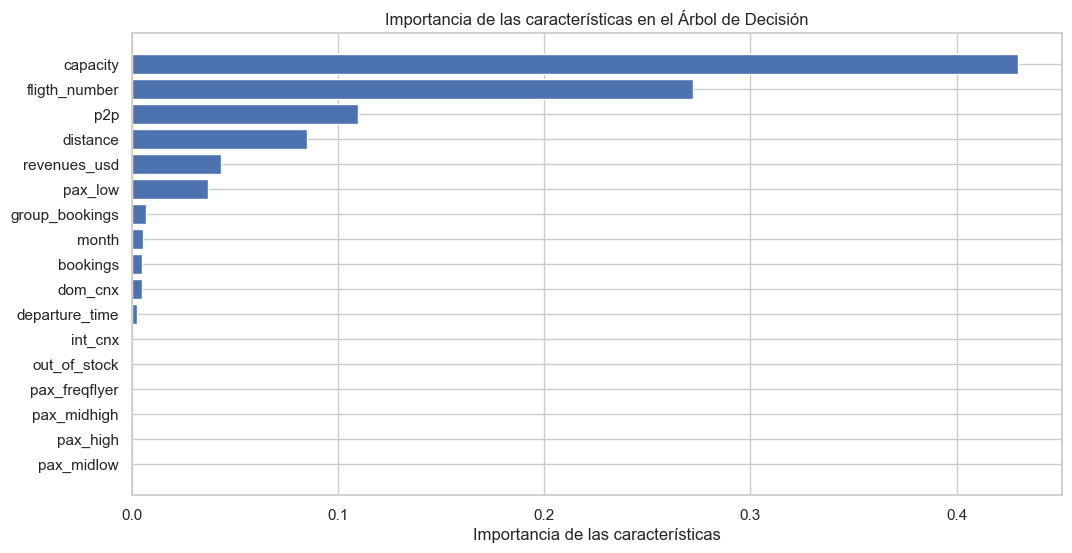

SMAPE promedio: 61.80122012369607


In [142]:
import numpy as np
import matplotlib.pyplot as plt

# Ajusta un árbol de decisión a tus datos
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(max_depth=5, random_state=42)
dtree.fit(X, y)

# Obtiene la importancia de las características
feature_importances = dtree.feature_importances_

# Obtiene el nombre de las características
feature_names = X.columns

# Combina los nombres de las características con sus importancias y luego ordena
feature_importance_names = list(zip(feature_names, feature_importances))
feature_importance_names.sort(key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_feature_importances = zip(*feature_importance_names)

# Crea un gráfico de barras para mostrar la importancia de las características
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(np.arange(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Importancia de las características')
plt.title('Importancia de las características en el Árbol de Decisión')
plt.show()

smape_scorer = make_scorer(smape, greater_is_better=False)
scores = cross_val_score(dtree, X, y, cv=5, scoring=smape_scorer)
print("SMAPE promedio:", -scores.mean())

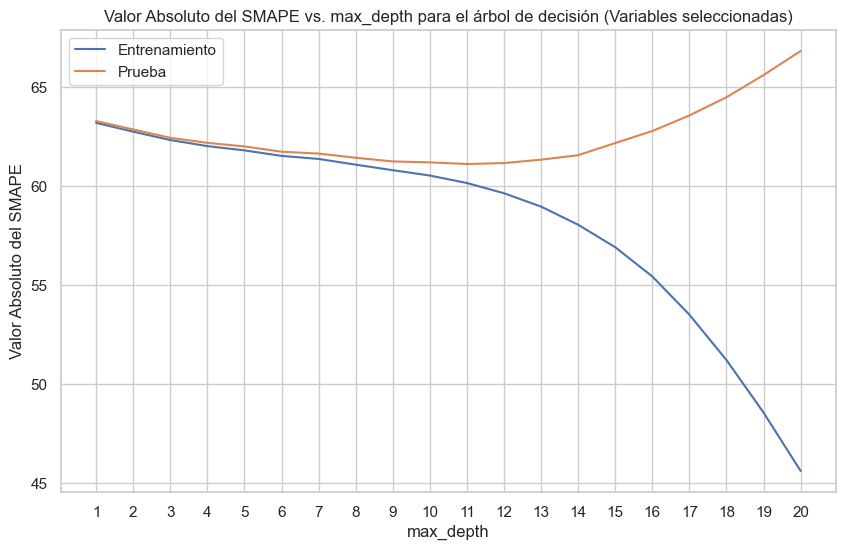

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

# Filtra el DataFrame original para incluir solo las columnas deseadas
selected_columns = ['capacity', 'fligth_number', 'p2p', 'distance', 'revenues_usd', 'pax_low']
X_selected = df_train_sample[selected_columns]
y = df_train_sample['noshow']

# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Define una lista de valores de max_depth que deseas probar
max_depth_values = range(1, 21)

# Inicializa listas para almacenar las puntuaciones de entrenamiento y prueba
train_smape = []
test_smape = []

# Realiza un bucle sobre los valores de max_depth
for max_depth in max_depth_values:
    # Crea un modelo de árbol de decisión con el valor actual de max_depth
    model = DecisionTreeRegressor(max_depth=max_depth)

    # Entrena el modelo en el conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Realiza las predicciones en el conjunto de entrenamiento
    y_pred_train = model.predict(X_train)

    # Calcula el SMAPE en el conjunto de entrenamiento
    train_smape_score = np.abs(smape(y_train, y_pred_train))

    # Realiza las predicciones en el conjunto de prueba
    y_pred_test = model.predict(X_test)

    # Calcula el SMAPE en el conjunto de prueba
    test_smape_score = np.abs(smape(y_test, y_pred_test))

    # Agrega los valores de SMAPE a las listas
    train_smape.append(train_smape_score)
    test_smape.append(test_smape_score)

# Crea un gráfico de max_depth vs. valor absoluto del SMAPE
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_smape, label='Entrenamiento')
plt.plot(max_depth_values, test_smape, label='Prueba')
plt.xlabel('max_depth')
plt.ylabel('Valor Absoluto del SMAPE')
plt.title('Valor Absoluto del SMAPE vs. max_depth para el árbol de decisión (Variables seleccionadas)')
plt.xticks(max_depth_values)
plt.legend()
plt.grid(True)
plt.show()


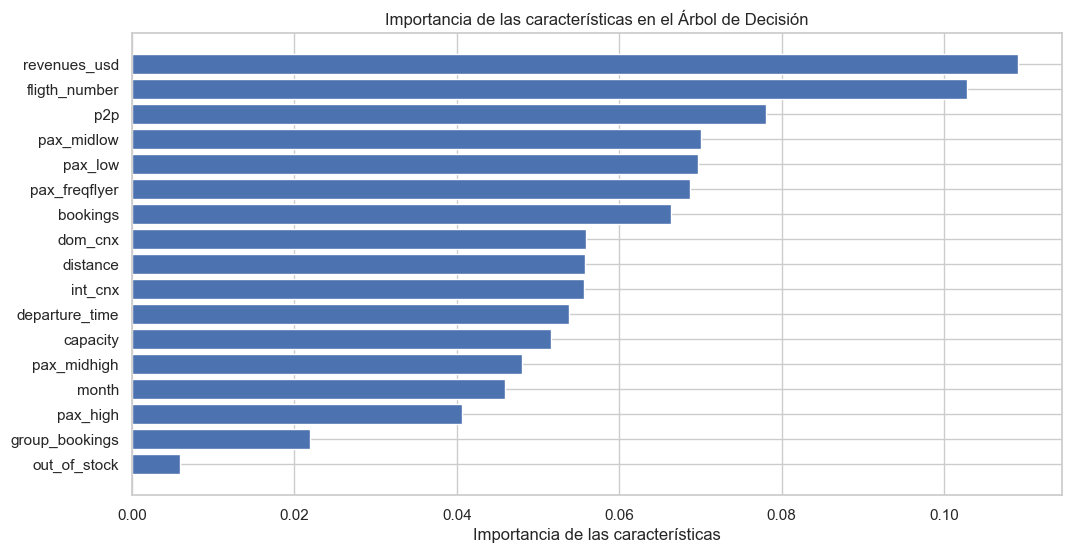

SMAPE promedio: 80.74492519363329


In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Ajusta un árbol de decisión SIN MAX DEPTH
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=42)
dtree.fit(X, y)

# Obtiene la importancia de las características
feature_importances = dtree.feature_importances_

# Obtiene el nombre de las características
feature_names = X.columns

# Combina los nombres de las características con sus importancias y luego ordena
feature_importance_names = list(zip(feature_names, feature_importances))
feature_importance_names.sort(key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_feature_importances = zip(*feature_importance_names)

# Crea un gráfico de barras para mostrar la importancia de las características
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(np.arange(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Importancia de las características')
plt.title('Importancia de las características en el Árbol de Decisión')
plt.show()

smape_scorer = make_scorer(smape, greater_is_better=False)
scores = cross_val_score(dtree, X, y, cv=5, scoring=smape_scorer)
print("SMAPE promedio:", -scores.mean())

# Resumen:
**kNN:**
- n=5: 'fligth_number', 'distance', 'departure_time', 'month', smape: 116.76
- n=10: 'fligth_number', 'distance', 'departure_time', 'capacity', smape: 119.35

**Regression tree:**
- max_depth=5: ['capacity', 'fligth_number', 'p2p', 'distance', 'revenues_usd', 'pax_low']

**Seleccionadas:**
- Sí o sí: 'fligth_number', 'distance', 'departure_time', 'month', 'capacity'
- Puede ser: 'p2p', 'revenues_usd', 'pax_low'


In [215]:
selected_features = ['fligth_number', 'distance', 'departure_time', 'month', 'capacity', 'p2p', 'revenues_usd', 'pax_low']

sample_size = round(956944/2) #PARA IR PROBANDO, CON TIEMPO HACERLO CON EL DF COMPLETO (NO SAMPLE)
df_train_sample = df_train.sample(n=sample_size, random_state=42) 

X = df_train_sample[selected_features]
y = df_train_sample['noshow']

# # Datos completos
# X = df_train[selected_features]
# y = df_train['noshow]

# Búsqueda de hiperparámetros y aplicación de kNN

Usando GridSearchCV:

In [216]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor

# # Define una secuencia de valores para n_neighbors
# n_neighbors_values = list(range(1, 500))

# # Define el param_grid con la secuencia de valores
# param_grid = {
#     'n_neighbors': n_neighbors_values
# }

# knn = KNeighborsRegressor()

# # Búsqueda con validación cruzada
# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=make_scorer(smape, greater_is_better=False))
# grid_search.fit(X, y)  # X e y son los datos de entrenamiento

# best_k = grid_search.best_params_['n_neighbors']
# print(best_k)

Usando RandomizedSearchCV:

In [217]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Define una secuencia de valores para n_neighbors
n_neighbors_values = list(range(1, 500))

knn_random = KNeighborsRegressor()

# Espacio de búsqueda de hiperparámetros
param_dist_knn = {
    'n_neighbors': n_neighbors_values
}

# Búsqueda con validación cruzada utilizando RandomizedSearchCV
n_iter_knn = 100
random_search = RandomizedSearchCV(knn_random, param_distributions=param_dist_knn, cv=5, scoring=make_scorer(smape, greater_is_better=False), n_iter=n_iter_knn, random_state=42)
random_search.fit(X, y)  # X e y son los datos de entrenamiento

best_k_random = random_search.best_params_['n_neighbors']
print(best_k_random)

64


Entrenar kNN usando el mejor parámetro encontrado con la búsqueda random

In [218]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Crear modelo KNeighborsRegressor con el mejor valor de n_neighbors best_k_random
knn_reg = KNeighborsRegressor(n_neighbors=best_k_random)

# Validación cruzada y calcula las métricas
smape_scores_knn = cross_val_score(knn_reg, X, y, cv=5, scoring=make_scorer(smape, greater_is_better=False))
mae_scores_knn = -cross_val_score(knn_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
mse_scores_knn = -cross_val_score(knn_reg, X, y, cv=5, scoring='neg_mean_squared_error')

mean_smape_knn = smape_scores_knn.mean()
std_smape_knn  = smape_scores_knn.std()
mean_mse_knn = mse_scores_knn.mean()
std_mse_knn = mse_scores_knn.std()
mean_mae_knn = mae_scores_knn.mean()
std_mae_knn = mae_scores_knn.std()

print("SMAPE:", -mean_smape_knn,'+-',std_smape_knn)
print("MAE:", mean_mae_knn,'+-',std_mae_knn)
print("MSE:", mean_mse_knn,'+-',std_mse_knn)

SMAPE: 61.68312355499802 +- 0.1483169125386727
MAE: 2.8113412347449693 +- 0.009789429137666308
MSE: 12.115652865378296 +- 0.060876702058982796


Ver de manera gráfica y vs y_pred

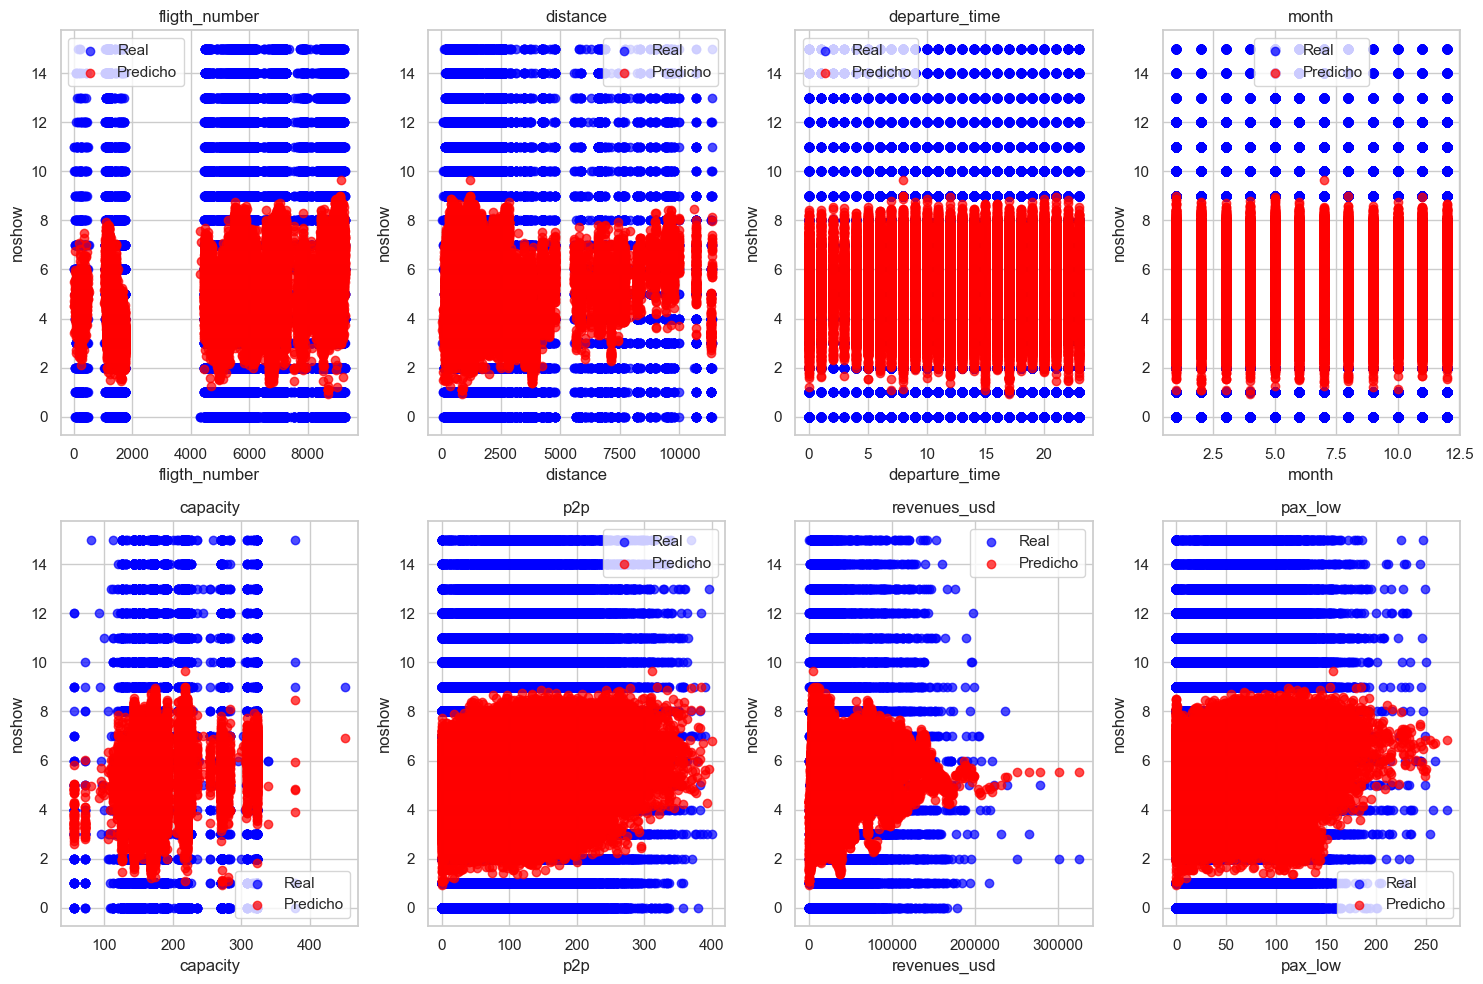

In [219]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Hacer los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_reg = KNeighborsRegressor(n_neighbors=best_k_random)

knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_test)

x_variables = X.columns
graphs_per_row = 4

num_rows = len(x_variables) // graphs_per_row
if len(x_variables) % graphs_per_row > 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 5 * num_rows))

if num_rows == 1:
    axes = [axes]

for i, variable in enumerate(x_variables):
    row, col = divmod(i, graphs_per_row)
    ax = axes[row][col]

    ax.scatter(X_test[variable], y_test, color='blue', label='Real', alpha=0.7)
    ax.scatter(X_test[variable], y_pred, color='red', label='Predicho', alpha=0.7)
    ax.set_xlabel(variable)
    ax.set_ylabel("noshow")
    ax.set_title(f"{variable}")
    ax.legend()

plt.tight_layout()
plt.show()

# Búsqueda de hiperparámetros y aplicación de regression tree

Usando GridSearchCV:

In [220]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer
# import numpy as np

# tree_reg = DecisionTreeRegressor()

# # DEspacio de búsqueda de hiperparámetros
# param_grid_tree = {
#     'max_depth': list(range(1, 51)),  # Valores para max_depth (1-50)
#     'min_samples_split': list(range(2, 21)),  # Valores para min_samples_split (2-20)
#     'min_samples_leaf': list(range(1, 21)),  # Valores para min_samples_leaf (1-20)
#     #'max_features': ['auto', 'sqrt', 'log2', None],  # Métodos para seleccionar características
#     #'criterion': ['mse', 'friedman_mse', 'mae'],  # Criterios para medir la calidad de la división
#     #'splitter': ['best', 'random'],  # Estrategias de división
# }

# # Búsqueda de hiperparámetros
# grid_search_tree = GridSearchCV(estimator=tree_reg, param_grid=param_grid_tree, cv=5, scoring=make_scorer(smape, greater_is_better=False))
# grid_search_tree.fit(X, y)

# # Mejores hiperparámetros y modelo
# best_max_depth = grid_search_tree.best_params_['max_depth']
# best_min_samples_split = grid_search_tree.best_params_['min_samples_split']
# best_min_samples_leaf = grid_search_tree.best_params_['min_samples_leaf']
# #best_max_features = grid_search_tree.best_params_['max_features']
# #best_criterion = grid_search_tree.best_params_['criterion']
# #best_splitter = grid_search_tree.best_params_['splitter']
# best_tree_reg = grid_search_tree.best_estimator_

# print("Mejor max_depth:", best_max_depth)
# print("Mejor min_samples_split:", best_min_samples_split)
# print("Mejor min_samples_leaf:", best_min_samples_leaf)
# #print("Mejor max_features:", best_max_features)
# #print("Mejor criterion:", best_criterion)
# #print("Mejor splitter:", best_splitter)
# print("Mejor modelo:", best_tree_reg)

Usando RandomizedSearchCV:

In [221]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

tree_reg_random = DecisionTreeRegressor()

# Espacio de búsqueda de hiperparámetros
param_dist_tree_random = {
    'max_depth': list(range(1, 51)),  # Valores para max_depth (1-50)
    'min_samples_split': list(range(2, 21)),  # Valores para min_samples_split (2-20)
    'min_samples_leaf': list(range(1, 21)),  # Valores para min_samples_leaf (1-20)
}

# Búsqueda de hiperparámetros con RandomizedSearchCV
n_iter_tree = 500
random_search_tree = RandomizedSearchCV(estimator=tree_reg_random, param_distributions=param_dist_tree_random, cv=5, scoring=make_scorer(smape, greater_is_better=False), n_iter=n_iter_tree, random_state=42)
random_search_tree.fit(X, y)

# Mejores hiperparámetros y modelo
best_max_depth_random = random_search_tree.best_params_['max_depth']
best_min_samples_split_random = random_search_tree.best_params_['min_samples_split']
best_min_samples_leaf_random = random_search_tree.best_params_['min_samples_leaf']
best_tree_reg_random = random_search_tree.best_estimator_

print("Mejor max_depth:", best_max_depth_random)
print("Mejor min_samples_split:", best_min_samples_split_random)
print("Mejor min_samples_leaf:", best_min_samples_leaf_random)
print("Mejor modelo:", best_tree_reg_random)

Mejor max_depth: 12
Mejor min_samples_split: 8
Mejor min_samples_leaf: 19
Mejor modelo: DecisionTreeRegressor(max_depth=12, min_samples_leaf=19, min_samples_split=8)


Entrenamiento del decision tree regressor con los parámetros encontrados:

Con los parámetros obtenidos en random:

In [222]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

best_tree_reg = DecisionTreeRegressor(
    max_depth=best_max_depth_random,
    min_samples_split=best_min_samples_split_random,
    min_samples_leaf=best_min_samples_leaf_random, 
    random_state=42
)

# Calcular SMAPE con cross validation
scores_best_tree_reg = cross_val_score(best_tree_reg, X, y, cv=10, scoring=make_scorer(smape, greater_is_better=False))

# print("Puntajes SMAPE en cada iteración de cross-validation:")
# print(-scores_best_tree_reg)

# Media y desviación estándar de los puntajes
mean_score = scores_best_tree_reg.mean()
std_score = scores_best_tree_reg.std()

print('SMAPE:', -mean_score,'+-',std_score)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cross-validation y para obtener los puntajes MSE y MAE
mse_scores = -cross_val_score(best_tree_reg, X, y, cv=10, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(best_tree_reg, X, y, cv=10, scoring='neg_mean_absolute_error')

mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print("MSE:", mean_mse,'+-',std_mse)
print("MAE:", mean_mae,'+-',std_mae)

SMAPE: 60.70096251185777 +- 0.18119357363958097
MSE: 11.532914955033238 +- 0.09382721959749135
MAE: 2.722728013263045 +- 0.011194964689836696


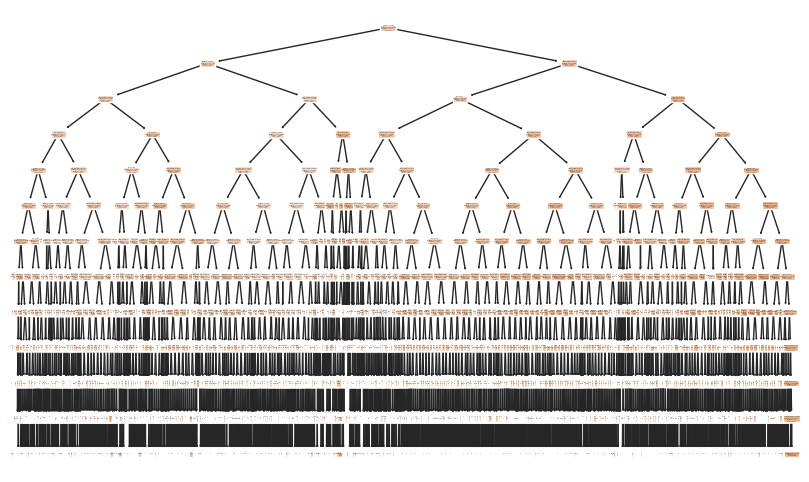

In [223]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_tree_reg.fit(X, y)

plt.figure(figsize=(10, 6))  
plot_tree(best_tree_reg, filled=True, feature_names=X.columns, class_names=True)  
plt.show()

Comparar gráficamente el valor predicho de 'noshow' vs el valor real ('y' vs 'y_pred'):

In [224]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_tree_reg.fit(X_train, y_train)
y_pred = best_tree_reg.predict(X_test)

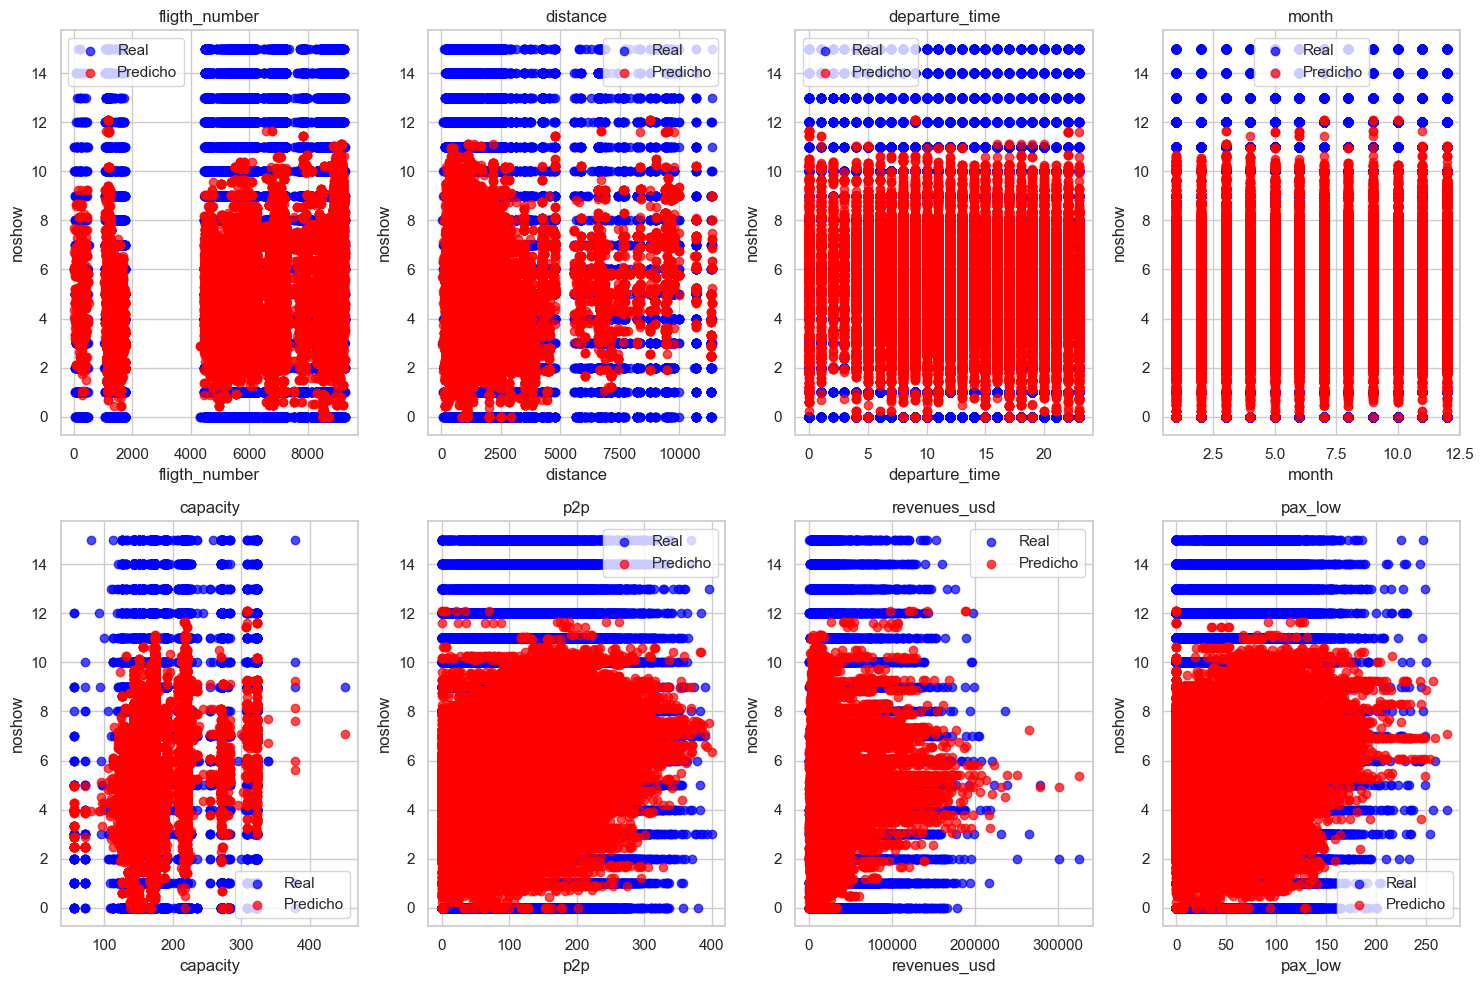

In [225]:
import matplotlib.pyplot as plt

x_variables = X.columns
graphs_per_row = 4

num_rows = len(x_variables) // graphs_per_row
if len(x_variables) % graphs_per_row > 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 5 * num_rows))

if num_rows == 1:
    axes = [axes]

for i, variable in enumerate(x_variables):
    row, col = divmod(i, graphs_per_row)
    ax = axes[row][col]

    ax.scatter(X_test[variable], y_test, color='blue', label='Real', alpha=0.7)
    ax.scatter(X_test[variable], y_pred, color='red', label='Predicho', alpha=0.7)
    ax.set_xlabel(variable)
    ax.set_ylabel("noshow")
    ax.set_title(f"{variable}")
    ax.legend()

plt.tight_layout()
plt.show()

# Comparación final entre el modelo seleccionado de kNN vs regression tree

# Competencia: predicción evalData